In [20]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df_bx = yf.download('BX', start='2014-01-01', progress=False)
df_bx["Date"] = df_bx.index

close_data = df_bx['Close']
close_data = close_data.values.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df_bx['Date'][:split]
date_test = df_bx['Date'][split:]

print(len(close_train))
print(len(close_test))

1778
445


In [22]:
# Turn the Close price into time series data

look_back = 15

train_generator = timeseries_dataset_from_array(close_train, close_train,)     
test_generator = timeseries_dataset_from_array(close_test, close_test, length=look_back, batch_size=1)

print(train_generator)

TypeError: timeseries_dataset_from_array() got an unexpected keyword argument 'length'

In [5]:
close_prices = df_bx['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])
    
print(len(x_train))    
print(len(y_train))

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

1689
1689


In [6]:
test_data = scaled_data[training_data_len-90: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(90, len(test_data)):
  x_test.append(test_data[i-90:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs = 1)

1689/1689 [==============================] - 136s 79ms/step - loss: 3.4595e-04


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

14/14 [==============================] - 1s 55ms/step


83.1523143880002

/tmp/ipykernel_1136/1724514044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


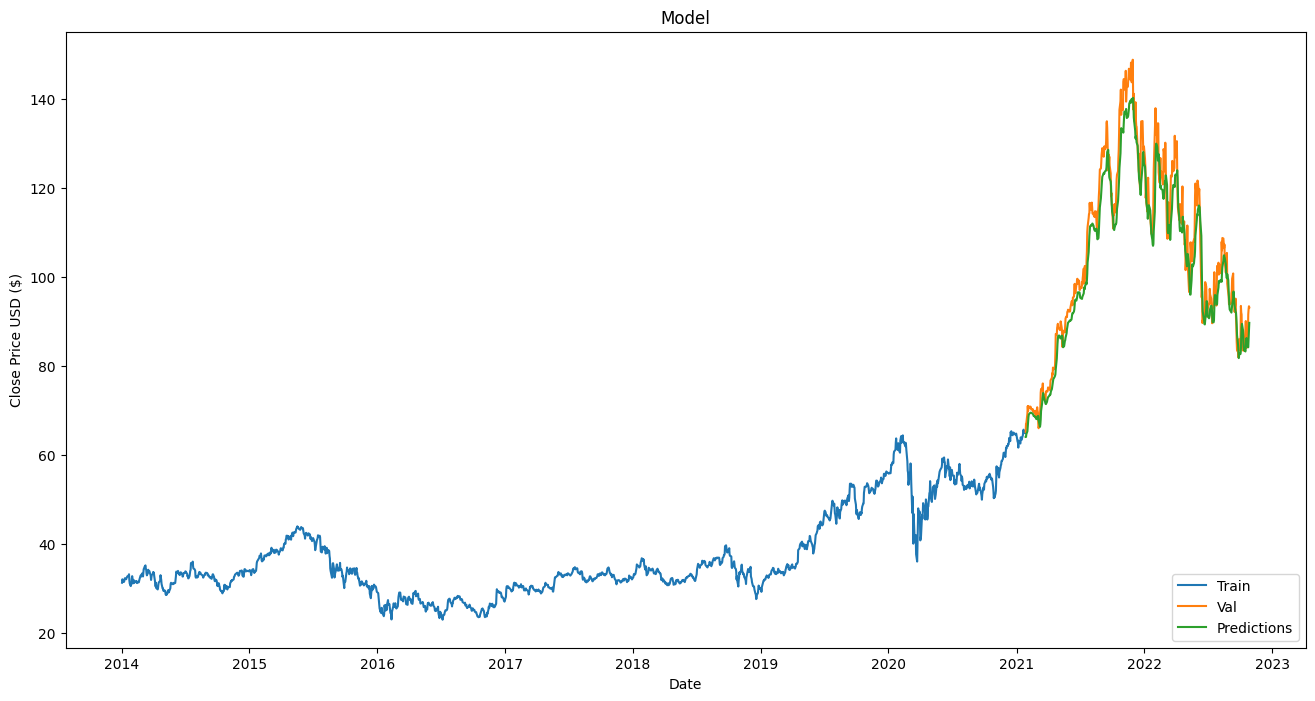

In [ ]:
data = df_bx.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# generate the multi-step forecasts
def multi_step_forecasts(n_past, n_future):
    global x_test

    #x_past = x[- n_past - 1:, :, :][:1]  # last observed input sequence
    x_past = np.append(x_test[- n_past - 1:, :],new_train_data)
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'Close': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

In [ ]:
# forecast the next 90 days
df1 = multi_step_forecasts(n_past=0, n_future=90)
df1.plot(title=stock_name)

# forecast the last 50 days and the next 90 days
df2 = multi_step_forecasts(n_past=50, n_future=90)
df2.plot(title=stock_name)

In [ ]:
new_predictions = []
count = 0
def entire_process(predictions):
    global count
    global new_predictions

    new_scaled_data = scaler.fit_transform(predictions.reshape(-1,1))
    #new_training_data_len = math.ceil(len(new_scaled_data)* 0.8)
    print(np.shape(new_scaled_data))
    new_train_data = new_scaled_data[0: 88, 0]

    print("length of new training data " + str(np.shape(new_train_data)))

    new_x_train = []
    new_y_train = []

    #for i in range(90, len(new_train_data)):
        #new_x_train.append(new_train_data[i-90:i, 0])
        #new_y_train.append(new_train_data[i, 0])

    #####new_x_train.append(new_train_data[0:88, 0])

    if len(new_train_data) < 179:
        ### May be wrong
        pick_x_train_from_this = np.append(new_scaled_data[len(new_scaled_data)-len(new_train_data):],new_train_data)
    else:
        pick_x_train_from_this = new_train_data
    
    for i in range (0,88):
        np.append(pick_x_train_from_this,[i + 88,0])
        new_y_train.append(new_train_data[i])
    
    print("length of new x training data" + str(len(new_x_train)))  
    print("length of new y training data" + str(len(new_y_train)))

    #new_x_train, new_y_train = np.array(new_x_train), np.array(new_y_train)
    #print(new_x_train)
    #new_x_train = np.reshape(new_x_train, (new_x_train.shape[0], new_x_train.shape[1], 1))
    #print(new_x_train)

    #new_test_data = new_scaled_data[new_training_data_len-90: , : ]
    new_y_test = new_scaled_data[89, 0]
    new_x_test = new_scaled_data[0:88,0]
    #new_y_test = predictions[new_training_data_len:]

    #for i in range(90, len(new_test_data)):
        #new_x_test.append(new_test_data[i-90:i, 0])
    
    #np.append(new_x_test,new_test_data[0:88, 0])

    #new_x_test = np.array(new_x_test)
    #new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))

    model.fit(new_x_train, new_y_train, batch_size= 1, epochs = 1)
    new_prediction = model.predict(new_x_test)
    new_prediction = scaler.inverse_transform(new_prediction)

    new_predictions.append(new_prediction)
    count = count + 1

    if count == 100:
        print("Done!")
    else:
        if len(new_predictions) < 90:
            print("I made it here")
            predictions_to_use = np.append(predictions[len(predictions)-len(new_predictions)-1:],new_predictions)
            print(len(predictions_to_use))
            entire_process(predictions_to_use)
        else:
            entire_process(new_predictions)

In [ ]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=4, batch_size=128, verbose=2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b00265c-0bcc-404a-942b-30b725de2b08' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>